### Optimization of n-D Gaussian Mixture Model (un-normalized)


$$ pdf(\mathbf{x}) = \sum_{k=1}^{K} c_k e^{-\frac{||\mathbf{x}-\mathbf{\mu}_k||^2}{s_k^2}} $$
$$ cost(\mathbf{x}) = 1-pdf(\mathbf{x}) $$ 

Here, $\mathbf{x} = (\mathbf{x}_{task},\mathbf{x}_{decision})$

The global optima is known apriori (approximately): The centers of the GMM are likely to be the maxima (or comparable to the optima). 

GMM can be really low-rank. We show that TTGO is able to find the global optima consistently with a hand few of samples from the constructed tt-model of the above pdf. Moreover, we can playfully choose task paramters as some of the coordinates of any of the centers (mixture component) in the online phase. Then, we can check if we get back the corresponding center (mixture component) as the optima. A naive approach of sampling from uniform distribution to initialize a Netwon-type optimizer does not usually work for larger $n$ (try $n>10$ in this notebook). We use scipy's SLSQP to fine tune the initialization provided by TTGO and uniform distribution.

Exercise:
   - Choose one of the mixture components to have larger weight than others (so that we have a unique global optima) and see if TTGO can get this global optima
   - Choose mutiple centers to have the same weight and higher than other centers (so that we have multiple global optima).Check if TTGO can get all of them
   - Select arbitrary number of axes as task-parmaters and choose the first few coordinates of a center as its value. Do you get back this center as optima?

Copyright (c) 2008 Idiap Research Institute, http://www.idiap.ch/
    Written by Suhan Shetty <suhan.shetty@idiap.ch>,


In [1]:
import torch
torch.set_default_dtype(torch.float32)

import numpy as np
import sys
sys.path.append('./fcn_opt')
sys.path.append('../')

from ttgo import TTGO
import tt_utils
from test_fcns import gmm
from fcn_plotting_utils import plot_surf, plot_contour

%load_ext autoreload
np.set_printoptions(precision=2)
torch.set_printoptions(precision=2)

%autoreload 2

/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-5btiok0l because the default path (/idiap/home/sshetty/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

#### Define the cost and the corresponding pdf

In [3]:
# Mixture of Gaussians (un-normalized)
L = 2
n = 5 # Dimension of the domain
nmix = 3
mx_coef = np.random.uniform(0,1,(nmix,))
# mx_coef[0]=mx_coef[1]
mx_coef = (torch.from_numpy(mx_coef/np.sum(mx_coef))).to(device)
mu = torch.from_numpy(np.random.uniform(-0.75*L,0.75*L,(nmix,n))).to(device)

mu[:,:-2] = mu[0,:-2] # for visualization, make the first (n-2) coordinates same (so that we can have it as task param)

pdf, cost = gmm(n=n,nmix=nmix,L=1,mx_coef=mx_coef,mu=mu,s=0.2, device=device)
print("centers: ",mu)
print("\nPDF at centers: ", pdf(mu))
print("Note: the center with the maximum pdf is the global optima")



centers:  tensor([[ 0.22,  0.40, -1.10, -0.22,  0.99],
        [ 0.22,  0.40, -1.10, -0.71, -1.09],
        [ 0.22,  0.40, -1.10, -1.39,  0.02]], device='cuda:0')

PDF at centers:  tensor([0.16, 0.37, 0.47], device='cuda:0')
Note: the center with the maximum pdf is the global optima


#### Define the domain and the discretization

In [4]:
# Define the domain of the function
domain = [torch.linspace(-L,L,100).to(device)]*(n)

In [5]:
# Find the tt-model correspondin to the pdf
tt_model = tt_utils.cross_approximate(fcn=pdf,  domain=domain, 
                        rmax=200, nswp=10, eps=1e-3, verbose=True, 
                        kickrank=10, device=device).to(device)

cross device is cuda
Cross-approximation over a 5D domain containing 1e+10 grid points:
iter: 0  | tt-error: 1.000e+00, test-error:6.643e-01 | time:   1.0890 | largest rank:   1
iter: 1  | tt-error: 8.383e-01, test-error:1.984e-15 | time:   1.1320 | largest rank:  11
iter: 2  | tt-error: 4.507e-08, test-error:3.104e-15 | time:   1.1901 | largest rank:  21 <- converged: eps < 0.001
Did 347700 function evaluations, which took 0.01682s (2.067e+07 evals/s)



### Fit the TT-Model

In [6]:
# Refine the discretization and interpolate the model
scale_factor = 20
site_list = torch.arange(len(domain))#len(domain_task)+torch.arange(len(domain_decision))
domain_new = tt_utils.refine_domain(domain=domain, 
                                    site_list=site_list,
                                    scale_factor=scale_factor, device=device)
tt_model_new = tt_utils.refine_model(tt_model=tt_model, 
                                    site_list=site_list,
                                    scale_factor=scale_factor, device=device)

In [7]:
ttgo = TTGO(tt_model=tt_model_new,domain=domain_new, cost=cost, device=device)

In [8]:
print("TT-Rank: ", ttgo.tt_model.ranks_tt)

TT-Rank:  tensor([1, 1, 1, 1, 3, 1])


### Sample from TT-Model

In [9]:
n_samples_tt = 100
alpha = 0.9
samples = ttgo.sample_tt(n_samples=n_samples_tt, alpha=alpha) 


### Choose the best sample as an estimate for optima (initial guess)

In [10]:
best_estimate = ttgo.choose_best_sample(samples)[0]
top_k_estimate = ttgo.choose_top_k_sample(samples,k=10)[0] # for multiple solutions

##### Fine-tune the estimate using gradient-based optimization

In [11]:
ttgo_optimized,_ = ttgo.optimize(best_estimate)

ttgo_optimized_k = 1*top_k_estimate
for i, x in enumerate(ttgo_optimized_k):
    ttgo_optimized_k[i],_ = ttgo.optimize(x)


In [12]:
print("PDF at the estimated point(initial guess): ", pdf(best_estimate))
print("PDF at the TTGO Optima: ", pdf(ttgo_optimized))

PDF at the estimated point(initial guess):  tensor([0.45], device='cuda:0')
PDF at the TTGO Optima:  tensor([0.47], device='cuda:0')


In [13]:
print("Estimated Optima: ", best_estimate)
print("Optima from TTGO: ", ttgo_optimized)

Estimated Optima:  tensor([[ 0.25,  0.32, -1.10, -1.38,  0.03]], device='cuda:0')
Optima from TTGO:  tensor([[ 0.22,  0.41, -1.10, -1.39,  0.02]], device='cuda:0')


### Compare with samples from uniform distribution (for initialization)

In [14]:
n_samples_rand = 10*n_samples_tt # Try increasing the number of samples! 
samples_rand = ttgo.sample_random(n_samples=n_samples_rand)

rand_best_estimate = ttgo.choose_best_sample(samples_rand)[0]
rand_optimized,_ = ttgo.optimize(rand_best_estimate, tol=1e-9)

print("PDF at the estimated point(initial guess): ", pdf(rand_best_estimate))
print("PDF at the Optima: ", pdf(rand_optimized))

PDF at the estimated point(initial guess):  tensor([0.10], device='cuda:0')
PDF at the Optima:  tensor([0.47], device='cuda:0')


In [15]:
rand_best_estimate

tensor([[ 0.70,  0.45, -1.04, -1.64, -0.05]], device='cuda:0')

### Let us try to specify some of the variables as the task parmaters

In [16]:
ttgo_2 = ttgo.clone()

Set the task parameters as the first few coordinated of one of the centers of the mixtures

In [17]:
k = torch.randint(low=0,high=nmix,size=(1,))[0] # choose a mixture component randomly
x_task = mu[k,:-2].view(1,-1) 
print("Task parameters: ",x_task)

Task parameters:  tensor([[ 0.22,  0.40, -1.10]], device='cuda:0')


In [18]:
# Collect Samples
n_samples_tt = 100
samples = ttgo_2.sample_tt(n_samples=n_samples_tt,x_task=x_task, alpha=0.9) 

# Filter the smaples
best_estimate = ttgo_2.choose_best_sample(samples)[0]
top_k_estimate = ttgo_2.choose_top_k_sample(samples,k=10)[0] # for multiple solutions

# Fine-tune

ttgo_optimized, _ = ttgo_2.optimize(best_estimate)

ttgo_optimized_k = 1*top_k_estimate
for i, x in enumerate(ttgo_optimized_k):
    ttgo_optimized_k[i], _ = ttgo.optimize(x)


print("PDF at the estimated point(initial guess): ", pdf(best_estimate))
print("PDF at the TTGO Optima: ", pdf(ttgo_optimized))

print("\nEstimated Optima: ", best_estimate)
print("Optima from TTGO: ", ttgo_optimized)

PDF at the estimated point(initial guess):  tensor([0.47], device='cuda:0')
PDF at the TTGO Optima:  tensor([0.47], device='cuda:0')

Estimated Optima:  tensor([[ 0.22,  0.40, -1.10, -1.40, -0.00]], device='cuda:0')
Optima from TTGO:  tensor([[ 0.22,  0.40, -1.10, -1.39,  0.02]], device='cuda:0')


In [19]:
# Redefinig the function given the coefficients
def cost_fcn(X):
    X = torch.from_numpy(X)
    X_ext = torch.empty(X.shape[0],len(domain))
    X_ext[:,:-2] = x_task
    X_ext[:,-2:] = X
    cost_ = pdf(X_ext.to(device)).cpu().numpy()
    return cost_


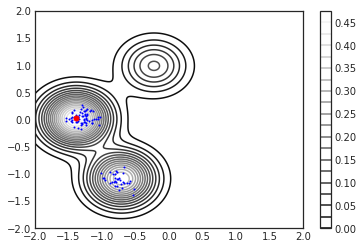

In [20]:
data = samples[0,:,-2:].cpu()
x = np.linspace(-L,L,500)
y = np.linspace(-L,L,500)

plt=plot_contour(x,y,cost_fcn,data=data, contour_scale=20, figsize=5, markersize=1,log_norm=False)
plt.plot(ttgo_optimized[:,-2].cpu(),ttgo_optimized[:,-1].cpu(),'.r',markersize=10)
# plt.xlabel("$y_{n_1-1}$")
# plt.ylabel("$y_{n_1}$")

# plt.savefig('gmm_n20_K5_s15_alpha10_ns1000_k10.png',pad_inches=0.01, dpi=300)
